# Spatial data Preprocessing

In [2]:
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 고도 데이터

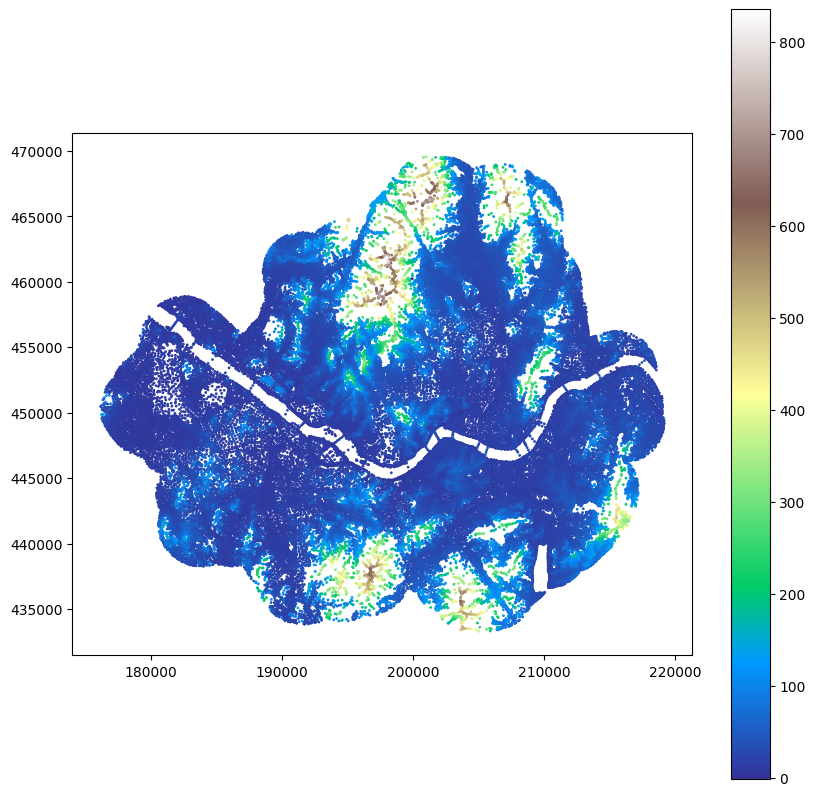

In [3]:
# Load the data
elevation = gpd.read_file('data/elevation/표고 5000/N3P_F002.shp') # crs 5174

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

elevation.plot(column='HEIGHT', ax=ax, legend=True, cmap='terrain', markersize=1)
plt.show() ## 그대로 사용하면 될듯

In [5]:
# roads = gpd.read_file('data/seoul_road/Z_KAIS_TL_SPRD_MANAGE_11.shp', encoding='euc-kr', crs='epsg:5179')
# roads = roads.to_crs('epsg:5174')
# roads = roads[roads.ROA_CLS_SE.isin(['1','2','3'])]

In [6]:
# 서울시 교통량 조사자료

traffic = pd.read_excel('data/traffic/04월 서울시 교통량 조사자료(2024).xlsx', sheet_name='2024년 04월')
traffic_info = pd.read_excel('data/traffic/04월 서울시 교통량 조사자료(2024).xlsx', sheet_name='수집지점 주소 및 좌표', skipfooter=4, usecols='A:E')
traffic_info = gpd.GeoDataFrame(traffic_info, geometry=gpd.points_from_xy(traffic_info['경도'], traffic_info['위도']), crs='wgs84')
traffic_info.to_crs(epsg=5174, inplace=True)

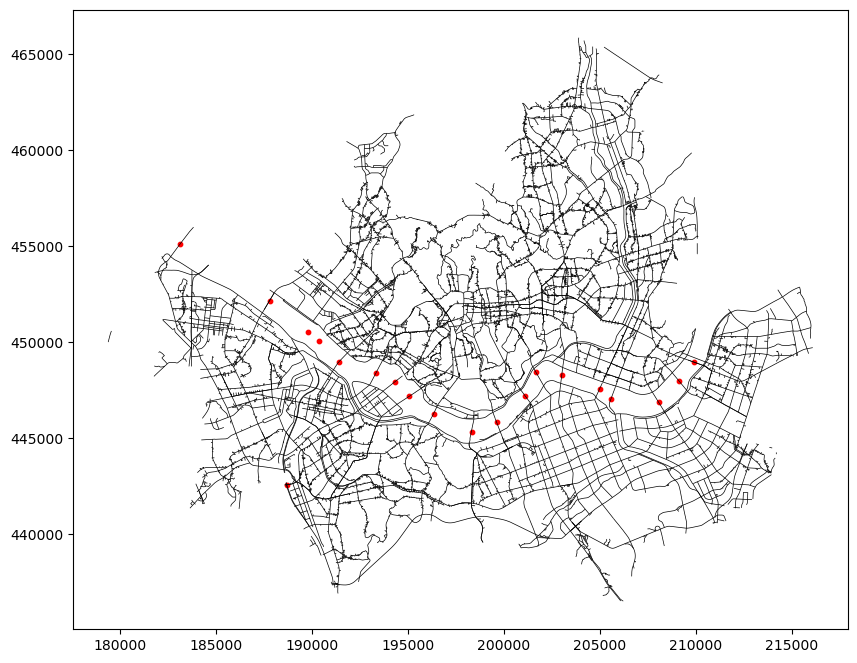

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# roads.plot(ax=ax, color='black', linewidth=0.5)
# traffic_info[traffic_info.지점명칭.str.contains('대교')].plot(ax=ax, color='red', markersize=10)
# plt.show()s

In [ ]:
# roads.to_file('data/seoul_road/seoul_road.shp')

# Using momepy

In [7]:
from src.linnet import Linnet, snap_points

roads = gpd.read_file('data/seoul_road/seoul_road.shp')

assert roads.crs == traffic_info.crs

# MultilineString to LineStrings
roads = roads.explode()

In [8]:
linnet = Linnet(roads)

snapped_df = snap_points(linnet, traffic_info)

# save

snapped_df.to_file('data/traffic/snap_traffic.shp')

In [11]:
linnet.shortest_path.shape

(17731, 17731)

In [26]:
# node_start and node_end of snapped_df to single array

nodes = snapped_df[['node_start', 'node_end']].values.flatten()
nodes.shape


## shortest_path matrix only for nodes

shortest_path = linnet.shortest_path[nodes][:, nodes]

In [29]:
# save

np.save('data/traffic/shortest_path.npy', shortest_path)